## Section3 Part1 Compare the highly correlated eccDNA (>90% overlap) 
#### Ke Liu

In [1]:
import subprocess as sp
import pandas as pd
import pysam as ps
import numpy as np
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.font_manager as font_manager
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
font_manager.fontManager.addfont('/home/qukun/liuke/miniconda3/fonts/Arial.ttf')
mpl.rcParams["font.sans-serif"] = "Arial"
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.serif'] = ['Arial']

In [2]:
def intersect(a,b,rate1,rate2,command,result):
    _shell2call = '/home/qukun/liuke/miniconda3/envs/eccDNA/bin/bedtools intersect -nonamecheck -a {0} -b {1} {2} {3} {4} > {5}'.format(a, b,rate1,rate2, command, result                                                                                                                                                  )
    sp.check_call(_shell2call, shell=True)
    return result

In [3]:
methods_list = ['WGS-SR','WGS-LR','ATAC-SR','3SEP-SR','3SEP-LR','Circle-Seq-SR','Circle-Seq-LR']
othername_list = ['NGS_WGS','Nanopore_WGS','ATAC','DSAT','DSRT7','DNARCAU','DNRT7']
methods_dict =dict(zip(othername_list,methods_list))

In [4]:
SR_methods = ['WGS-SR','ATAC-SR','3SEP-SR','Circle-Seq-SR']
LR_methods = ['WGS-LR','3SEP-LR','Circle-Seq-LR']

In [5]:
sample_list = ['{0}{1}'.format(a,b) for a in othername_list for b in range(1,4)]

In [6]:
ratio_plot=pd.DataFrame(columns=sample_list, index=sample_list )
num_plot=pd.DataFrame(columns=sample_list, index=sample_list )
mask=pd.DataFrame(columns=sample_list, index=sample_list)

In [7]:
for i in range(len(sample_list)):
    imethod = methods_dict[sample_list[i][:-1]]
    if imethod in SR_methods:
        iecc = '/home/qukun/liuke/workspace/benchmark/result/2nd/filtered/'+sample_list[i]+'.bed'
    elif imethod in LR_methods:
        iecc = '/home/qukun/liuke/workspace/benchmark/result/3rd/filtered/'+sample_list[i]+'.bed'
    locals()[sample_list[i]] = pd.read_csv(iecc, sep='\t', header=None)
    locals()[sample_list[i]+'_num'] = len(locals()[sample_list[i]][3].unique())

In [8]:
result_path = '/home/qukun/liuke/workspace/benchmark/result/hetero/'
for i in range(len(sample_list)):
    imethod = methods_dict[sample_list[i][:-1]]
    if imethod in SR_methods:
        iecc = '/home/qukun/liuke/workspace/benchmark/result/2nd/filtered/'+sample_list[i]+'.bed'
    elif imethod in LR_methods:
        iecc = '/home/qukun/liuke/workspace/benchmark/result/3rd/filtered/'+sample_list[i]+'.bed'
    for j in range(i,len(sample_list)):
        jmethod = methods_dict[sample_list[j][:-1]]
        if jmethod in SR_methods:
            jecc = '/home/qukun/liuke/workspace/benchmark/result/2nd/filtered/'+sample_list[j]+'.bed'
        elif jmethod in LR_methods:
            jecc = '/home/qukun/liuke/workspace/benchmark/result/3rd/filtered/'+sample_list[j]+'.bed'
        intersect(iecc, jecc,'-f 0.9','-F 0.9','-wa -wb',result_path+sample_list[i]+'_'+sample_list[j]+'.bed')
        if(len(open(result_path+sample_list[i]+'_'+sample_list[j]+'.bed','r').readlines())!=0):
            locals()[sample_list[i]+'_'+sample_list[j]]=pd.read_csv(result_path+sample_list[i]+'_'+sample_list[j]+'.bed',sep='\t',header=None)
        else:
            locals()[sample_list[i]+'_'+sample_list[j]]=''

In [9]:
for i in range(len(sample_list)):
    for j in range(i,len(sample_list)):
        mask.loc[sample_list[j],sample_list[i]]=False
        if(len(open(result_path+sample_list[i]+'_'+sample_list[j]+'.bed','r').readlines())!=0):
            ratio_plot.loc[sample_list[i],sample_list[j]] = len(locals()[sample_list[i]+'_'+sample_list[j]][3].unique())/locals()[sample_list[i]+'_num']
            ratio_plot.loc[sample_list[j],sample_list[i]] = len(locals()[sample_list[i]+'_'+sample_list[j]][10].unique())/locals()[sample_list[j]+'_num']
            num_plot.loc[sample_list[i],sample_list[j]] = len(locals()[sample_list[i]+'_'+sample_list[j]][3].unique())
            num_plot.loc[sample_list[j],sample_list[i]] = len(locals()[sample_list[i]+'_'+sample_list[j]][10].unique())
        else:
            ratio_plot.loc[sample_list[i],sample_list[j]] = 0
            ratio_plot.loc[sample_list[j],sample_list[i]] = 0
            num_plot.loc[sample_list[i],sample_list[j]] = 0
            num_plot.loc[sample_list[j],sample_list[i]] = 0

In [13]:
ratio_plot= ratio_plot.astype(float)
num_plot= num_plot.astype(float)

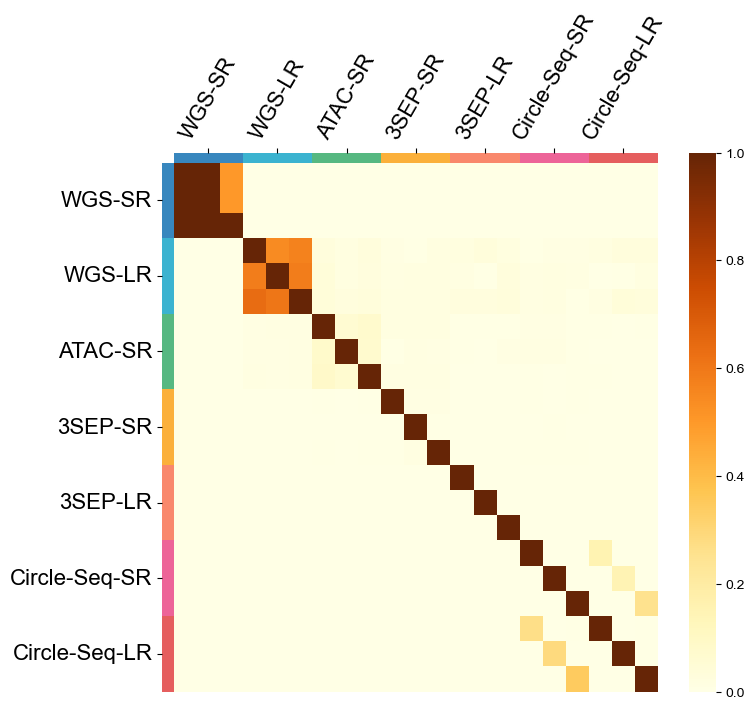

In [14]:
fig, ax1 = plt.subplots(figsize=(8,7))
sns.heatmap(data=ratio_plot.loc[sample_list,sample_list],cmap=sns.color_palette("YlOrBr", as_cmap=True), vmin=0, vmax=1)
ax1.set_xticks(ticks=[i-0.5 for i in list(range(2,21,3))],labels=methods_list,rotation=60,fontsize=16)
ax1.set_yticks(ticks=[i-0.5 for i in list(range(2,21,3))],labels=methods_list,fontsize=16)

plt.bar(-0.25, 3, bottom=0, width=0.5, color='#3887be')
plt.bar(-0.25, 3, bottom=3, width=0.5, color='#3bb3d0')
plt.bar(-0.25, 3, bottom=6, width=0.5, color='#56b881')
plt.bar(-0.25, 3, bottom=9, width=0.5, color='#fbb03b')
plt.bar(-0.25, 3, bottom=12, width=0.5, color='#f9886c')
plt.bar(-0.25, 3, bottom=15, width=0.5, color='#ed6498')
plt.bar(-0.25, 3, bottom=18, width=0.5, color='#e55e5e')

plt.bar([0.5,1.5,2.5], 0.5, bottom=-0.5, width=1, color='#3887be')
plt.bar([3.5,4.5,5.5], 0.5, bottom=-0.5, width=1, color='#3bb3d0')
plt.bar([6.5,7.5,8.5], 0.5, bottom=-0.5, width=1, color='#56b881')
plt.bar([9.5,10.5,11.5], 0.5, bottom=-0.5, width=1, color='#fbb03b')
plt.bar([12.5,13.5,14.5], 0.5, bottom=-0.5, width=1, color='#f9886c')
plt.bar([15.5,16.5,17.5], 0.5, bottom=-0.5, width=1, color='#ed6498')
plt.bar([18.5,19.5,20.5], 0.5, bottom=-0.5, width=1, color='#e55e5e')

ax1.set_xlim(-0.5,21)
ax1.set_ylim(-0.4,21)
ax1.invert_yaxis()
ax1.xaxis.set_ticks_position('top')
ratio_plot.to_csv('/home/qukun/liuke/workspace/benchmark/Figure/figure3a_eccDNA_conservative_ratio.csv')
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/figure3a_eccDNA_conservative_ratio.pdf', dpi=300, bbox_inches='tight')

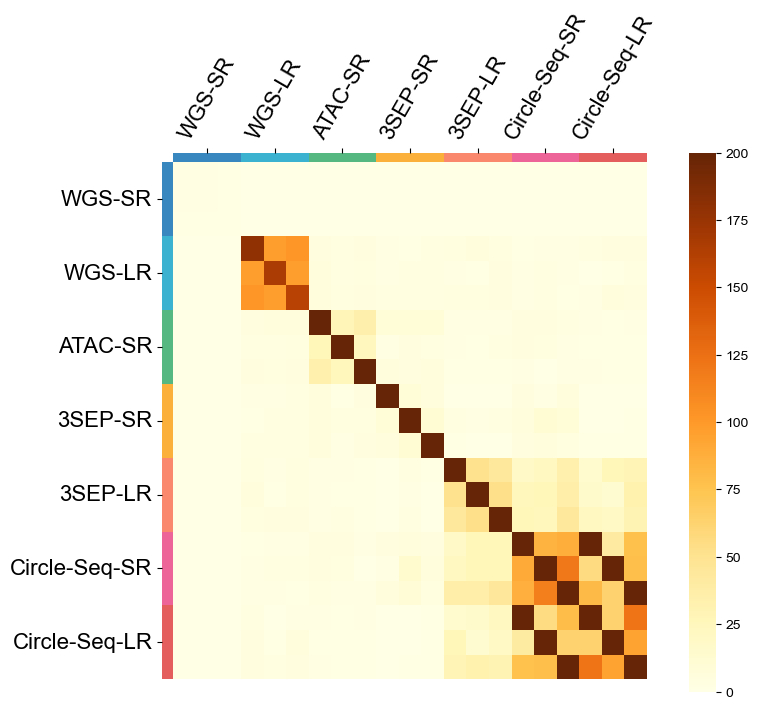

In [15]:
fig, ax1 = plt.subplots(figsize=(8,7))
sns.heatmap(data=num_plot.loc[sample_list,sample_list],cmap=sns.color_palette("YlOrBr", as_cmap=True), vmin=0, vmax=200)
ax1.set_xticks(ticks=[i-0.5 for i in list(range(2,21,3))],labels=methods_list,rotation=60,fontsize=16)
ax1.set_yticks(ticks=[i-0.5 for i in list(range(2,21,3))],labels=methods_list,fontsize=16)
plt.bar(-0.25, 3, bottom=0, width=0.5, color='#3887be')
plt.bar(-0.25, 3, bottom=3, width=0.5, color='#3bb3d0')
plt.bar(-0.25, 3, bottom=6, width=0.5, color='#56b881')
plt.bar(-0.25, 3, bottom=9, width=0.5, color='#fbb03b')
plt.bar(-0.25, 3, bottom=12, width=0.5, color='#f9886c')
plt.bar(-0.25, 3, bottom=15, width=0.5, color='#ed6498')
plt.bar(-0.25, 3, bottom=18, width=0.5, color='#e55e5e')

plt.bar([0.5,1.5,2.5], 0.5, bottom=-0.5, width=1, color='#3887be')
plt.bar([3.5,4.5,5.5], 0.5, bottom=-0.5, width=1, color='#3bb3d0')
plt.bar([6.5,7.5,8.5], 0.5, bottom=-0.5, width=1, color='#56b881')
plt.bar([9.5,10.5,11.5], 0.5, bottom=-0.5, width=1, color='#fbb03b')
plt.bar([12.5,13.5,14.5], 0.5, bottom=-0.5, width=1, color='#f9886c')
plt.bar([15.5,16.5,17.5], 0.5, bottom=-0.5, width=1, color='#ed6498')
plt.bar([18.5,19.5,20.5], 0.5, bottom=-0.5, width=1, color='#e55e5e')
ax1.set_xlim(-0.5,21.5)
ax1.set_ylim(-0.4,21.5)
ax1.invert_yaxis()
ax1.xaxis.set_ticks_position('top')
num_plot.to_csv('/home/qukun/liuke/workspace/benchmark/Figure/figure3b_eccDNA_conservative_num.csv')
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/figure3b_eccDNA_conservative_num.pdf', dpi=300, bbox_inches='tight')